In [3]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)

import statsmodels.api as sm
import ast
import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.utils import resample
import seaborn as sns
from matplotlib import pyplot as plt
from joblib import Parallel, delayed

rd = pd.read_excel('./Resources/combined_phecodex_list.xlsx')
cd = rd.loc[rd['Type'] == 'Common']

def cb(series):
    return series.apply(lambda x: 1 if x > 0 else 0)

CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

# Optional plotting function
if True:
    import os
    import matplotlib
    import matplotlib.font_manager as font_manager

    font_path = '/sc/arion/projects/GENECAD/Robert/arial.ttf'
    assert os.path.exists(font_path)
    font_manager.fontManager.addfont(font_path)
    prop = font_manager.FontProperties(fname=font_path)

    matplotlib.rc('font', family='sans-serif')
    matplotlib.rcParams.update({
        'font.size': 12,
        'font.sans-serif': prop.get_name(),
        'axes.titlesize': 12
    })

def bootstrap_ci(y_true, y_pred, n_bootstraps=1000, alpha=0.05):
    bootstrapped_scores = {'auroc': [], 'auprc': []}
    indices = np.arange(len(y_true))
    for _ in range(n_bootstraps):
        sampled_indices = resample(indices, replace=True)
        bootstrapped_scores['auroc'].append(roc_auc_score(y_true[sampled_indices], y_pred[sampled_indices]))
        bootstrapped_scores['auprc'].append(average_precision_score(y_true[sampled_indices], y_pred[sampled_indices]))

    ci = {}
    for score_type in bootstrapped_scores:
        sorted_scores = np.sort(bootstrapped_scores[score_type])
        lower = np.percentile(sorted_scores, 100 * alpha / 2)
        upper = np.percentile(sorted_scores, 100 * (1 - alpha / 2))
        mean = np.mean(sorted_scores)
        ci[score_type] = (lower, mean, upper)
    return ci
    
def bootstrap_ci_parallel_joblib(y_true, y_pred, n_bootstraps=1000, alpha=0.05, seed=42, n_jobs=-1, return_samples=False):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    n = y_true.shape[0]

    def _one(i):
        rng = np.random.default_rng(seed + i)
        idx = rng.integers(0, n, size=n, endpoint=False)
        yt = y_true[idx]; yp = y_pred[idx]
        if yt.min() == yt.max():
            return None
        return float(roc_auc_score(yt, yp)), float(average_precision_score(yt, yp))

    res = Parallel(n_jobs=n_jobs, backend="loky", prefer="processes")(
        delayed(_one)(i) for i in range(n_bootstraps)
    )
    aurocs = [a for a in (r[0] if r else None for r in res) if a is not None]
    auprcs = [p for p in (r[1] if r else None for r in res) if p is not None]

    def _ci(arr):
        arr = np.asarray(arr)
        return (float(np.percentile(arr, 2.5)),
                float(np.mean(arr)),
                float(np.percentile(arr, 97.5)))

    result = {'auroc': _ci(aurocs), 'auprc': _ci(auprcs)}
    
    if return_samples:
        result['auroc_samples'] = np.array(aurocs)
        result['auprc_samples'] = np.array(auprcs)
    
    return result

def weighted_bootstrap_average(all_auroc_samples, all_auprc_samples, weights, n_iterations=10000, seed=42):
    """
    Compute weighted average of metrics with bootstrap CI.
    
    Parameters:
    -----------
    all_auroc_samples : list of arrays
        Each array contains bootstrap samples for one subset
    all_auprc_samples : list of arrays
        Each array contains bootstrap samples for one subset
    weights : array-like
        Sample sizes or weights for each subset
    n_iterations : int
        Number of Monte Carlo iterations
    seed : int
        Random seed
        
    Returns:
    --------
    dict with 'auroc' and 'auprc' CIs (lower, mean, upper)
    """
    rng = np.random.default_rng(seed)
    weights = np.asarray(weights, dtype=float)
    weights = weights / weights.sum()  # Normalize to sum to 1
    
    auroc_avgs = []
    auprc_avgs = []
    
    for _ in range(n_iterations):
        # Sample one bootstrap value from each subset's distribution
        auroc_vals = [rng.choice(samples) for samples in all_auroc_samples]
        auprc_vals = [rng.choice(samples) for samples in all_auprc_samples]
        
        # Compute weighted average
        auroc_avgs.append(np.average(auroc_vals, weights=weights))
        auprc_avgs.append(np.average(auprc_vals, weights=weights))
    
    auroc_avgs = np.array(auroc_avgs)
    auprc_avgs = np.array(auprc_avgs)
    
    return {
        'auroc': (float(np.percentile(auroc_avgs, 2.5)),
                  float(np.mean(auroc_avgs)),
                  float(np.percentile(auroc_avgs, 97.5))),
        'auprc': (float(np.percentile(auprc_avgs, 2.5)),
                  float(np.mean(auprc_avgs)),
                  float(np.percentile(auprc_avgs, 97.5)))
    }

In [4]:
alldata = pd.read_pickle('./Final/ml_input.pkl')

alldata['xscore'] = 0.0
alldata.loc[alldata['phase'] == 0.5, 'xscore'] = 1*0.732*0.548*0.580*0.911
alldata.loc[alldata['phase'] == 1, 'xscore'] = 1*0.732*0.548*0.580
alldata.loc[alldata['phase'] == 2, 'xscore'] = 1*0.732*0.548
alldata.loc[alldata['phase'] == 3, 'xscore'] = 1*0.732
alldata.loc[alldata['phase'] == 4, 'xscore'] = 1

indata = alldata.loc[alldata['drug_gene'] == 1]

ind = indata.groupby('phecode')['indication'].max().reset_index()
ind = ind.loc[ind['indication'] == 1]
indata = indata.loc[indata['phecode'].isin(ind['phecode'])]
print(indata['phecode'].nunique())

#####

clin = ['clingen','eva','gene2phenotype','genomics_england','orphanet','uniprot_literature', 'uniprot_variants']
ot = ['clin_ot','hgmd','gwas_credible_sets','expression_atlas','impc','europepmc']
mantis = ['mantis']
cc = ['cc_common_max_p','cc_rare_max_p','cc_rare_burden_max_p','cc_ultrarare_max_p']

112


## Sensitivity 1: Gene holdout

In [4]:
# Get dataset size and number indicated
df = pd.read_pickle('./GPS/Sensitivity/gene_holdout_predictions_ot_mantis_cc.pkl')
print(len(df), df['indication'].sum())

356272 5912


In [10]:
# Run bootstrap for metrics by gene bucket
print('Gene holdout')
pdf = pd.read_pickle('./GPS/Sensitivity/gene_holdout_predictions_ot_mantis_cc.pkl').reset_index(drop=True)

results = []
all_auroc_samples = []
all_auprc_samples = []
sample_sizes = []

# Individual gene buckets
for bucket in sorted(pdf['bucket'].unique()):
    print(f'  Bucket: {bucket}')
    bucket_df = pdf[pdf['bucket'] == bucket]
    
    auroc = roc_auc_score(bucket_df['indication'], bucket_df['prediction'])
    auprc = average_precision_score(bucket_df['indication'], bucket_df['prediction'])
    ci = bootstrap_ci_parallel_joblib(bucket_df['indication'], bucket_df['prediction'], return_samples=True)
    
    results.append({'Analysis': f'Bucket {bucket}',
                    'AUROC': auroc, 'AUROC_CI': ci['auroc'],
                    'AUPRC': auprc, 'AUPRC_CI': ci['auprc']})
    print(f"    AUROC: {auroc:.4f}, AUPRC: {auprc:.4f}")
    
    # Save for weighted average
    all_auroc_samples.append(ci['auroc_samples'])
    all_auprc_samples.append(ci['auprc_samples'])
    sample_sizes.append(len(bucket_df))

# Overall weighted average
print('  Overall (weighted average)')
overall_ci = weighted_bootstrap_average(all_auroc_samples, all_auprc_samples, sample_sizes)

results.append({'Analysis': 'Overall',
                'AUROC': overall_ci['auroc'][1], 'AUROC_CI': overall_ci['auroc'],
                'AUPRC': overall_ci['auprc'][1], 'AUPRC_CI': overall_ci['auprc']})
print(f"    AUROC: {overall_ci['auroc'][1]:.4f}, AUPRC: {overall_ci['auprc'][1]:.4f}")

res_df = pd.DataFrame(results)
res_df.to_excel('./Results/bootstrap_metrics_sensitivity_gene.xlsx', index=False)
print(f"\nSaved {len(results)} results to Excel")

Gene holdout
  Bucket: 1
    AUROC: 0.7056, AUPRC: 0.0658
  Bucket: 2
    AUROC: 0.6910, AUPRC: 0.0586
  Bucket: 3
    AUROC: 0.6919, AUPRC: 0.0583
  Bucket: 4
    AUROC: 0.7002, AUPRC: 0.0573
  Bucket: 5
    AUROC: 0.7028, AUPRC: 0.0683
  Overall (weighted average)
    AUROC: 0.6983, AUPRC: 0.0623

Saved 6 results to Excel


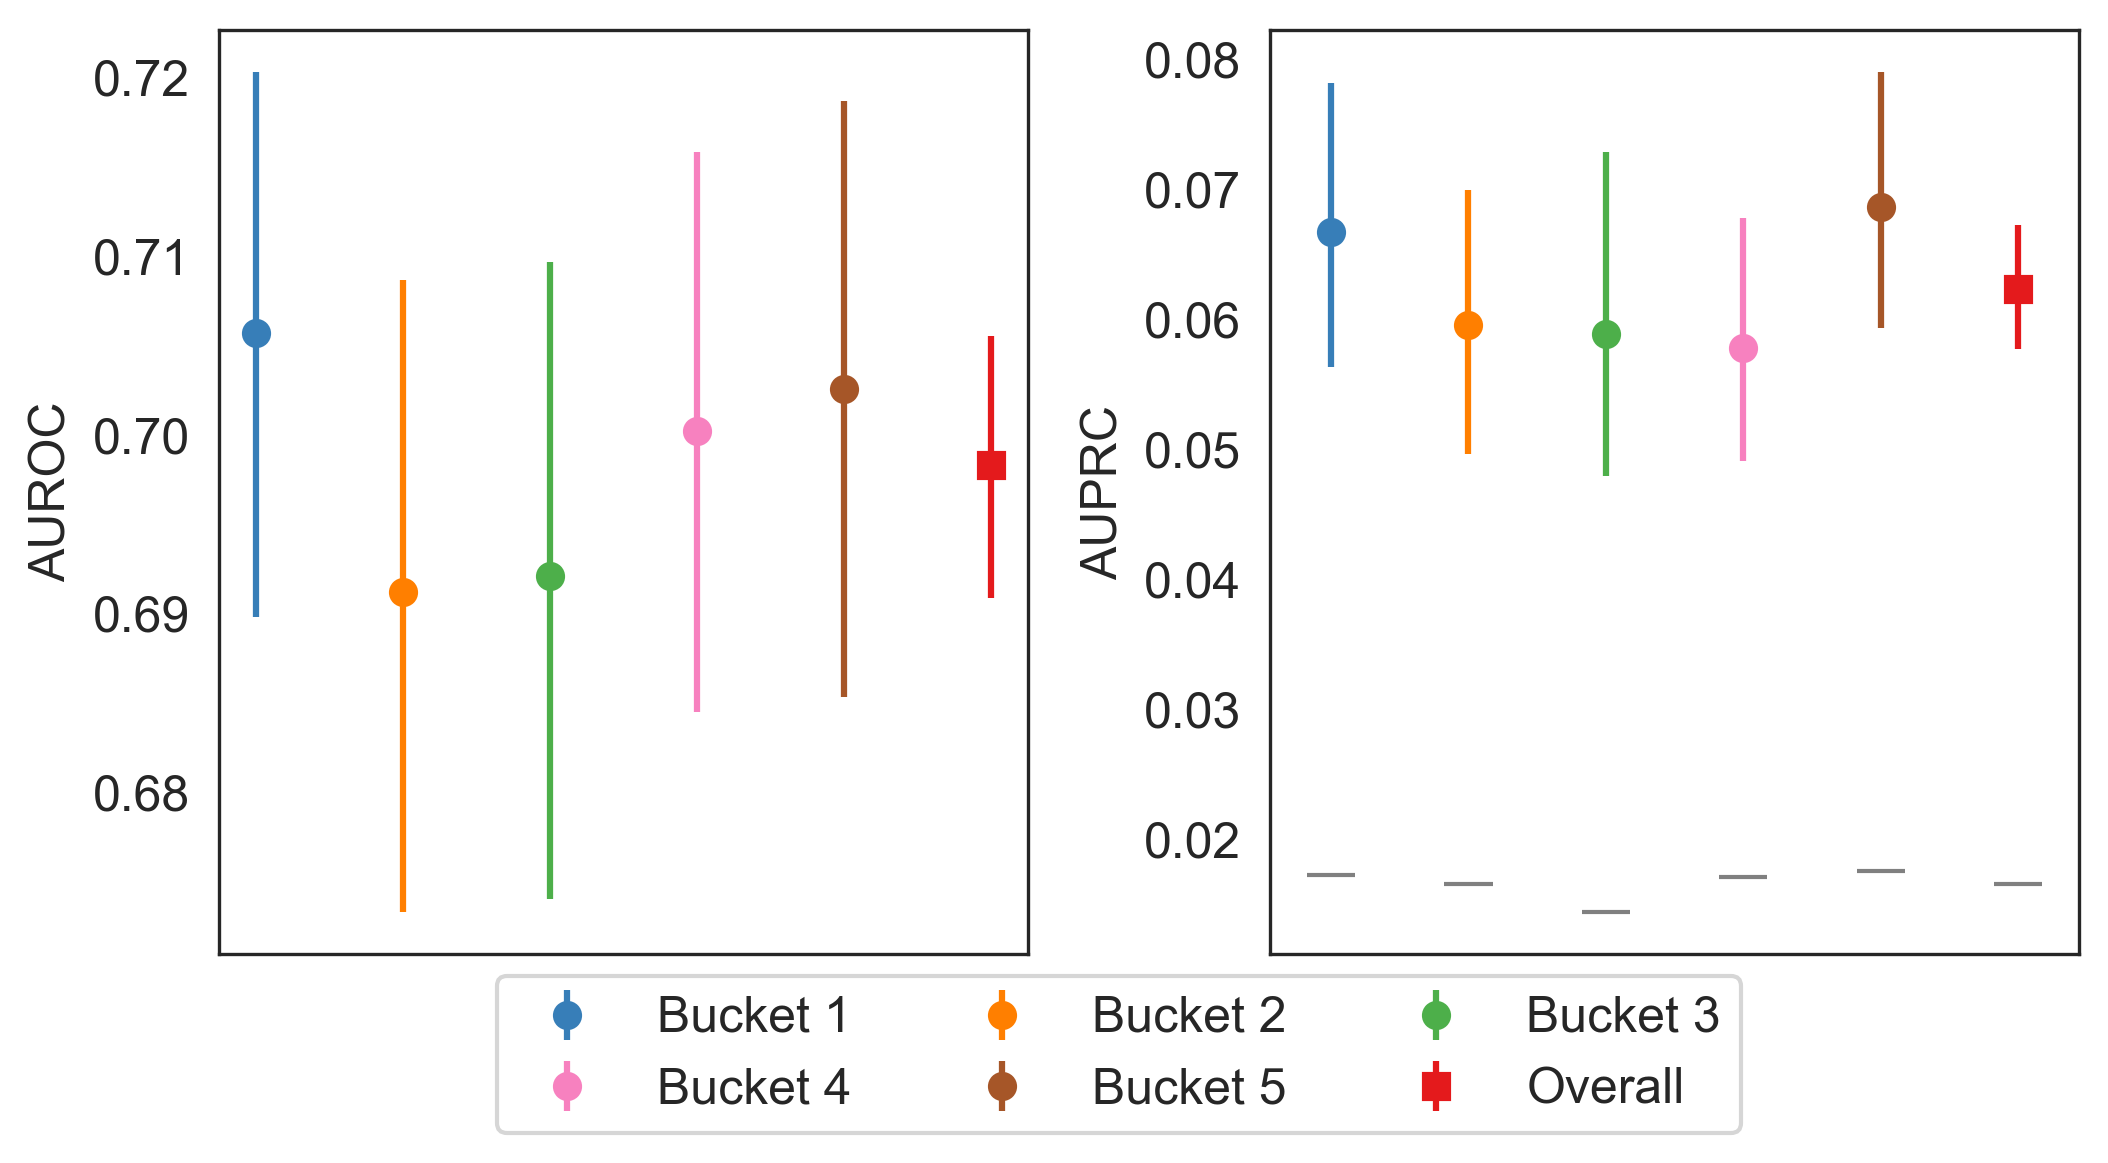

In [9]:
# Generate plot
metrics = pd.read_excel('./Results/bootstrap_metrics_sensitivity_gene.xlsx')

# Data prep (AUROC)
auroc_df = metrics.copy()
auroc_df['AUROC_mean'] = auroc_df['AUROC_CI'].apply(lambda x: ast.literal_eval(x)[1]).astype(float)
auroc_df['AUROC_CI_lower'] = auroc_df['AUROC_CI'].apply(lambda x: ast.literal_eval(x)[0]).astype(float)
auroc_df['AUROC_CI_upper'] = auroc_df['AUROC_CI'].apply(lambda x: ast.literal_eval(x)[2]).astype(float)
auroc_df['error_lower'] = auroc_df['AUROC_mean'] - auroc_df['AUROC_CI_lower']
auroc_df['error_upper'] = auroc_df['AUROC_CI_upper'] - auroc_df['AUROC_mean']

# Data prep (AUPRC)
# Calculate baseline proportion for each bucket and weighted average for Overall
pdf = pd.read_pickle('./GPS/Sensitivity/gene_holdout_predictions_ot_mantis_cc.pkl')
bucket_props = pdf.groupby('bucket')['indication'].mean().to_dict()
bucket_sizes = pdf.groupby('bucket').size().to_dict()

# Calculate weighted average base rate for Overall
total_size = sum(bucket_sizes.values())
weighted_prop = sum(bucket_props[b] * bucket_sizes[b] for b in bucket_props.keys()) / total_size

auprc_df = metrics.copy()
auprc_df['Proportion'] = auprc_df['Analysis'].apply(
    lambda x: bucket_props[int(x.split()[-1])] if 'Bucket' in x else weighted_prop
)
auprc_df['AUPRC_mean'] = auprc_df['AUPRC_CI'].apply(lambda x: ast.literal_eval(x)[1]).astype(float)
auprc_df['AUPRC_CI_lower'] = auprc_df['AUPRC_CI'].apply(lambda x: ast.literal_eval(x)[0]).astype(float)
auprc_df['AUPRC_CI_upper'] = auprc_df['AUPRC_CI'].apply(lambda x: ast.literal_eval(x)[2]).astype(float)
auprc_df['error_lower'] = auprc_df['AUPRC_mean'] - auprc_df['AUPRC_CI_lower']
auprc_df['error_upper'] = auprc_df['AUPRC_CI_upper'] - auprc_df['AUPRC_mean']

# Define desired order for legend
desired_order = ['Bucket 1', 'Bucket 2', 'Bucket 3', 'Bucket 4', 'Bucket 5', 'Overall']

# Figure with two subplots
sns.set_style('white')
fig, axes = plt.subplots(1, 2, figsize=(8, 4), dpi=300, constrained_layout=False)
fig.subplots_adjust(wspace=0.3)
width = 0.175

# -------- Left panel: AUROC --------
ax = axes[0]
analyses = auroc_df['Analysis'].unique()
x = np.arange(len(analyses))

for i, analysis in enumerate(analyses):
    data = auroc_df[auroc_df['Analysis'] == analysis]
    # Use different marker for Overall
    marker = 's' if analysis == 'Overall' else 'o'
    color = '#e41a1c' if analysis == 'Overall' else CB_color_cycle[i % len(CB_color_cycle)]
    
    ax.errorbar(
        x[i],
        data['AUROC_mean'].values[0],
        yerr=[[data['error_lower'].values[0]], [data['error_upper'].values[0]]],
        fmt=marker, capsize=0, label=analysis, color=color, markersize=6
    )

ax.set_xticks(x)
ax.set_xticklabels([])
ax.set_ylabel('AUROC')
ax.set_xlabel('')

# -------- Right panel: AUPRC --------
ax = axes[1]
analyses2 = auprc_df['Analysis'].unique()
x2 = np.arange(len(analyses2))

for i, analysis in enumerate(analyses2):
    data = auprc_df[auprc_df['Analysis'] == analysis]
    # Use different marker for Overall
    marker = 's' if analysis == 'Overall' else 'o'
    color = '#e41a1c' if analysis == 'Overall' else CB_color_cycle[i % len(CB_color_cycle)]
    
    ax.errorbar(
        x2[i],
        data['AUPRC_mean'].values[0],
        yerr=[[data['error_lower'].values[0]], [data['error_upper'].values[0]]],
        fmt=marker, capsize=0, label=analysis, color=color, markersize=6
    )
    
    # Horizontal baseline
    prop = data['Proportion'].iloc[0]
    if pd.notnull(prop):
        ax.hlines(y=prop, xmin=x2[i]-width, xmax=x2[i]+width, color='gray', linestyle='-', linewidth=1)

ax.set_xticks(x2)
ax.set_xticklabels([])
ax.set_ylabel('AUPRC')

# -------- Single legend below (row-wise visual order) --------
handles, labels = axes[0].get_legend_handles_labels()
label_to_handle = dict(zip(labels, handles))
handles_ord = [label_to_handle[l] for l in desired_order]
labels_ord = desired_order

ncol = 3
n = len(labels_ord)
nrows = int(np.ceil(n / ncol))
perm = np.arange(nrows * ncol).reshape(nrows, ncol).ravel(order='F')
perm = perm[perm < n]

fig.legend([handles_ord[i] for i in perm],
           [labels_ord[i]  for i in perm],
           loc='lower center', ncol=ncol,
           bbox_to_anchor=(0.5, -0.06))

plt.show()

## Sensitivity 2: Phecode category holdout

In [13]:
# Get dataset size and number indicated
df = pd.read_pickle('./GPS/Sensitivity/loo_holdout_predictions_ot_mantis_cc.pkl')
print(len(df), df['indication'].sum())

356272 5912


In [14]:
# Run bootstrap for metrics by phecode category
pdf = pd.read_pickle('./GPS/Sensitivity/loo_holdout_predictions_ot_mantis_cc.pkl').reset_index(drop=True)

# Phecode category counts
phecode_counts = indata.groupby('phecode_category')['indication'].sum().to_dict()

results = []
all_auroc_samples = []
all_auprc_samples = []
sample_sizes = []

# Individual phecode categories
for category in sorted(pdf['phecode_category'].unique()):
    print(f'Phecode category: {category}')
    cat_df = pdf[pdf['phecode_category'] == category]
    if len(cat_df) == 0 or cat_df['indication'].sum() == 0:
        print(f"  Skipping {category} - no positive samples")
        continue
    
    auroc = roc_auc_score(cat_df['indication'], cat_df['prediction'])
    auprc = average_precision_score(cat_df['indication'], cat_df['prediction'])
    ci = bootstrap_ci_parallel_joblib(cat_df['indication'], cat_df['prediction'], return_samples=True)
    
    count = phecode_counts.get(category, 0)
    results.append({'Category':category, 'Count':count,
                    'AUROC':auroc, 'AUROC_CI': ci['auroc'],
                    'AUPRC':auprc, 'AUPRC_CI': ci['auprc']})
    print(f"  AUROC: {auroc:.4f}, AUPRC: {auprc:.4f}")
    
    # Save for weighted average
    all_auroc_samples.append(ci['auroc_samples'])
    all_auprc_samples.append(ci['auprc_samples'])
    sample_sizes.append(len(cat_df))

# Overall weighted average
print('Overall (weighted average)')
overall_ci = weighted_bootstrap_average(all_auroc_samples, all_auprc_samples, sample_sizes)

total_count = indata['indication'].sum()
results.append({'Category': 'Overall', 'Count': int(total_count),
                'AUROC': overall_ci['auroc'][1], 'AUROC_CI': overall_ci['auroc'],
                'AUPRC': overall_ci['auprc'][1], 'AUPRC_CI': overall_ci['auprc']})
print(f"  AUROC: {overall_ci['auroc'][1]:.4f}, AUPRC: {overall_ci['auprc'][1]:.4f}")

res_df = pd.DataFrame(results)
res_df.to_excel('./Results/bootstrap_metrics_sensitivity_phecode.xlsx', index=False)
print(f"\nSaved {len(results)} results to Excel")

Phecode category: BI
  AUROC: 0.6153, AUPRC: 0.0280
Phecode category: CM
  AUROC: 0.7113, AUPRC: 0.0635
Phecode category: CV
  AUROC: 0.7308, AUPRC: 0.0775
Phecode category: DE
  AUROC: 0.6972, AUPRC: 0.0235
Phecode category: EM
  AUROC: 0.7196, AUPRC: 0.0756
Phecode category: GE
  AUROC: 0.6733, AUPRC: 0.0692
Phecode category: GI
  AUROC: 0.6665, AUPRC: 0.0437
Phecode category: GU
  AUROC: 0.6176, AUPRC: 0.1017
Phecode category: MB
  AUROC: 0.6616, AUPRC: 0.0669
Phecode category: MS
  AUROC: 0.7125, AUPRC: 0.0449
Phecode category: NS
  AUROC: 0.6394, AUPRC: 0.0642
Phecode category: RE
  AUROC: 0.5687, AUPRC: 0.0066
Phecode category: SO
  AUROC: 0.7165, AUPRC: 0.0954
Overall (weighted average)
  AUROC: 0.6765, AUPRC: 0.0624

Saved 14 results to Excel


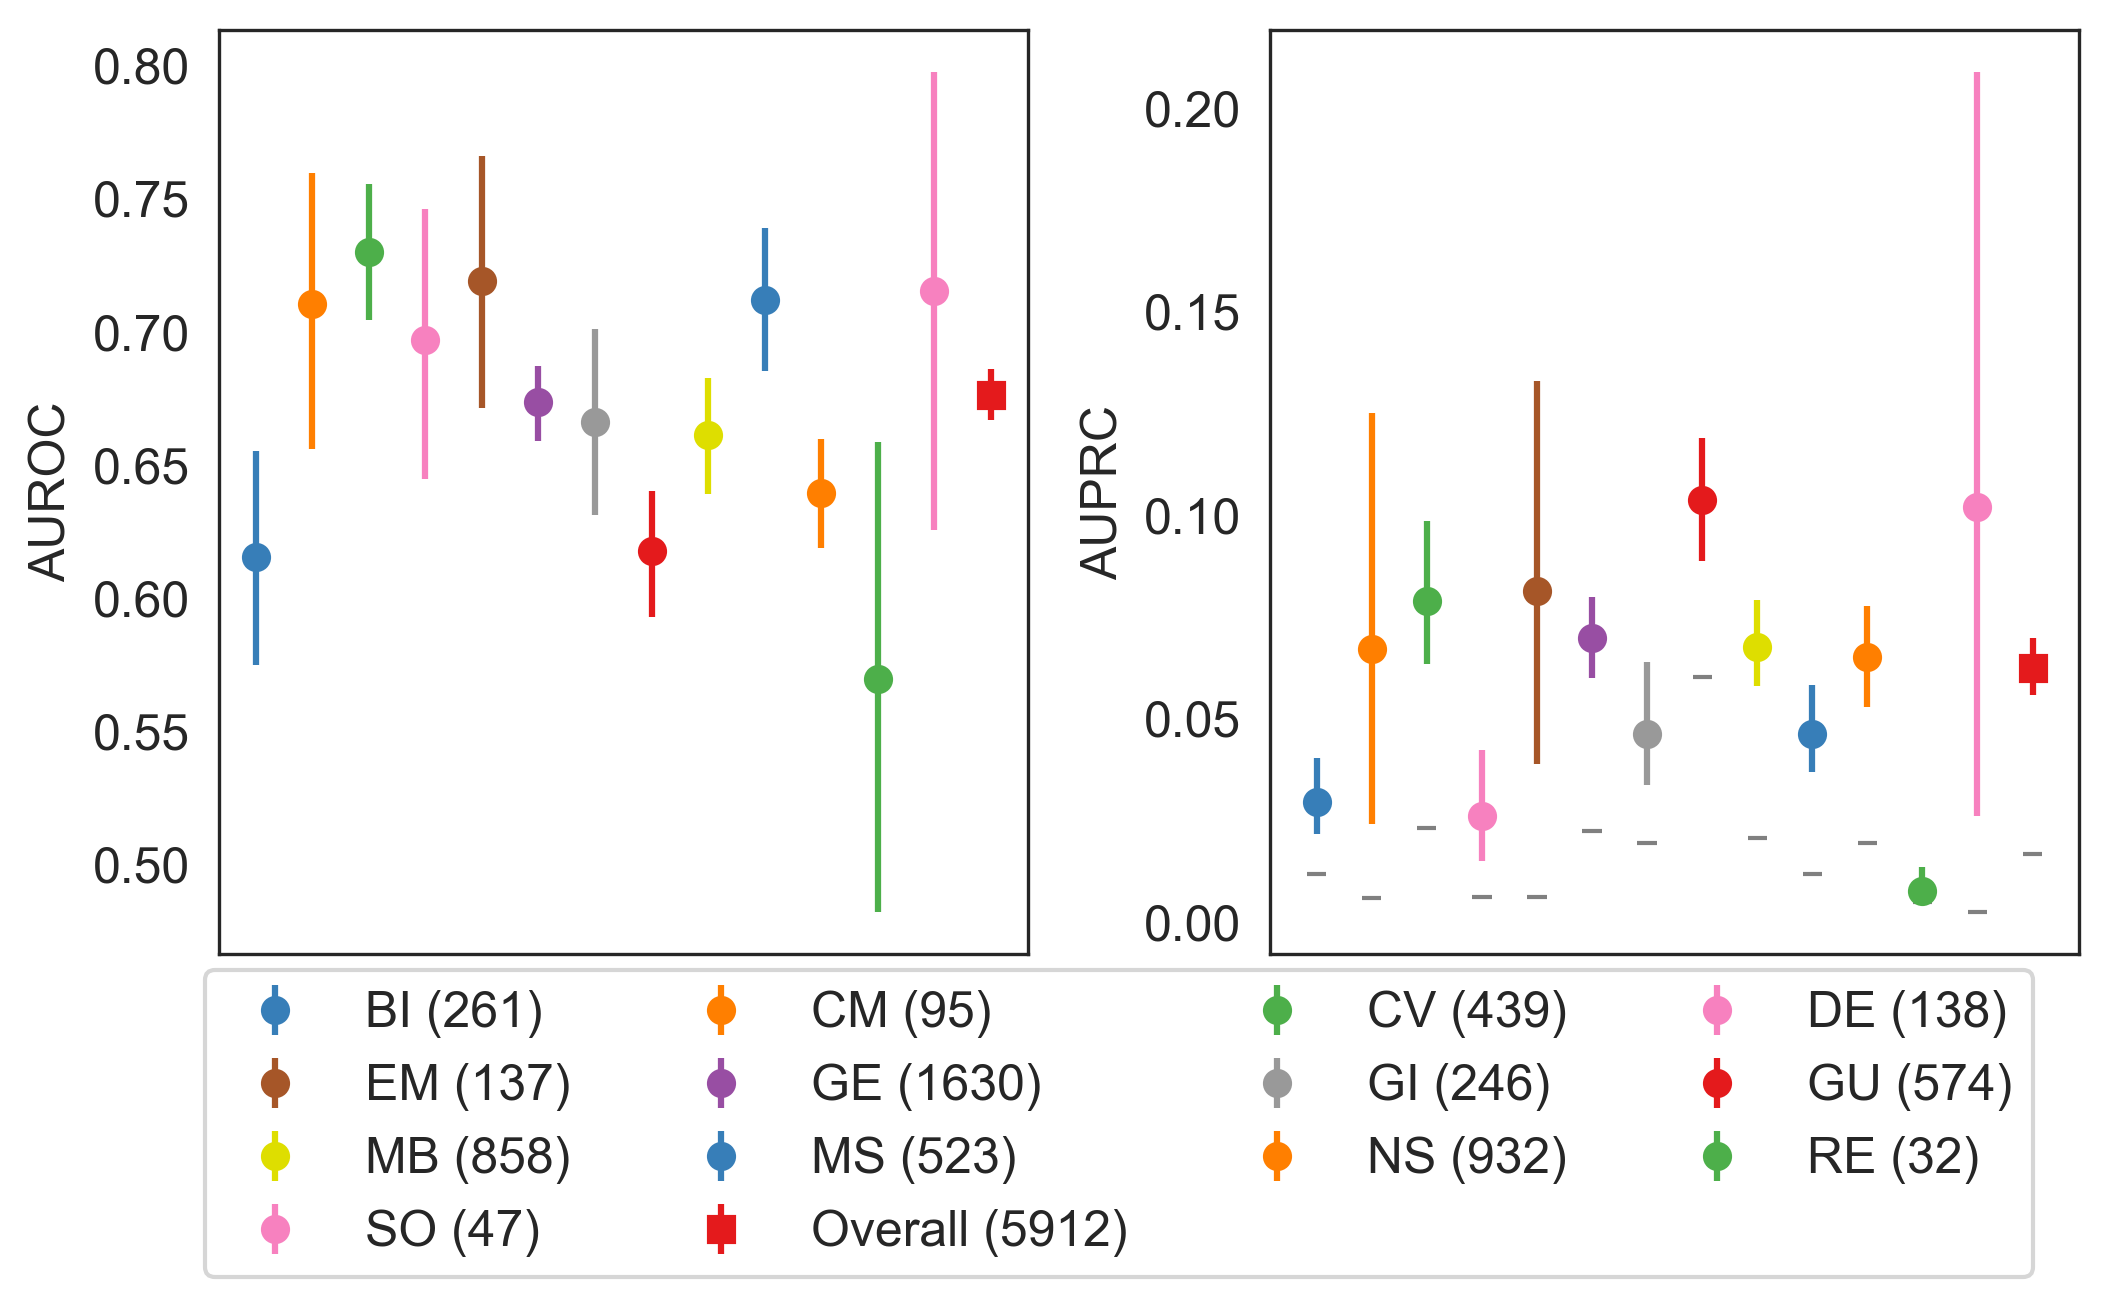

In [18]:
# Generate plot
metrics = pd.read_excel('./Results/bootstrap_metrics_sensitivity_phecode.xlsx')

# Data prep (AUROC)
auroc_df = metrics.copy()
auroc_df['AUROC_mean'] = auroc_df['AUROC_CI'].apply(lambda x: ast.literal_eval(x)[1]).astype(float)
auroc_df['AUROC_CI_lower'] = auroc_df['AUROC_CI'].apply(lambda x: ast.literal_eval(x)[0]).astype(float)
auroc_df['AUROC_CI_upper'] = auroc_df['AUROC_CI'].apply(lambda x: ast.literal_eval(x)[2]).astype(float)
auroc_df['error_lower'] = auroc_df['AUROC_mean'] - auroc_df['AUROC_CI_lower']
auroc_df['error_upper'] = auroc_df['AUROC_CI_upper'] - auroc_df['AUROC_mean']
auroc_df['Label'] = auroc_df.apply(
    lambda row: row['Category'] if row['Category'] == 'Overall' 
                else row['Category'] + ' (' + str(row['Count']) + ')', axis=1)

# Data prep (AUPRC)
pdf = pd.read_pickle('./GPS/Sensitivity/loo_holdout_predictions_ot_mantis_cc.pkl')
category_props = pdf.groupby('phecode_category')['indication'].mean().to_dict()
category_sizes = pdf.groupby('phecode_category').size().to_dict()

# Calculate weighted average base rate for Overall
categories_in_results = [row['Category'] for _, row in metrics.iterrows() if row['Category'] != 'Overall']
total_size = sum(category_sizes[cat] for cat in categories_in_results if cat in category_sizes)
weighted_prop = sum(category_props[cat] * category_sizes[cat] for cat in categories_in_results if cat in category_sizes) / total_size
category_props['Overall'] = weighted_prop

auprc_df = metrics.copy()
auprc_df['Proportion'] = auprc_df['Category'].map(category_props)
auprc_df['AUPRC_mean'] = auprc_df['AUPRC_CI'].apply(lambda x: ast.literal_eval(x)[1]).astype(float)
auprc_df['AUPRC_CI_lower'] = auprc_df['AUPRC_CI'].apply(lambda x: ast.literal_eval(x)[0]).astype(float)
auprc_df['AUPRC_CI_upper'] = auprc_df['AUPRC_CI'].apply(lambda x: ast.literal_eval(x)[2]).astype(float)
auprc_df['error_lower'] = auprc_df['AUPRC_mean'] - auprc_df['AUPRC_CI_lower']
auprc_df['error_upper'] = auprc_df['AUPRC_CI_upper'] - auprc_df['AUPRC_mean']
auprc_df['Label'] = auprc_df.apply(
    lambda row: row['Category'] if row['Category'] == 'Overall' 
                else row['Category'] + ' (' + str(row['Count']) + ')', axis=1)

# Figure with two subplots
sns.set_style('white')
fig, axes = plt.subplots(1, 2, figsize=(8, 4), dpi=300, constrained_layout=False)
fig.subplots_adjust(wspace=0.3)
width = 0.175

# -------- Left panel: AUROC --------
ax = axes[0]
categories = auroc_df['Category'].unique()
x = np.arange(len(categories))

for i, category in enumerate(categories):
    cat_data = auroc_df[auroc_df['Category'] == category]
    # Use different marker and color for Overall
    marker = 's' if category == 'Overall' else 'o'
    if category == 'Overall':
        color = '#e41a1c'
        label = 'Overall (' + str(cat_data['Count'].values[0]) + ')'
    else:
        color = CB_color_cycle[i % len(CB_color_cycle)]
        label = cat_data['Label'].values[0]
    
    ax.errorbar(
        x[i],
        cat_data['AUROC_mean'].values[0],
        yerr=[[cat_data['error_lower'].values[0]], [cat_data['error_upper'].values[0]]],
        fmt=marker, capsize=0, label=label, color=color, markersize=6
    )

ax.set_xticks(x)
ax.set_xticklabels([])
ax.set_ylabel('AUROC')
ax.set_xlabel('')

# -------- Right panel: AUPRC --------
ax = axes[1]
categories2 = auprc_df['Category'].unique()
x2 = np.arange(len(categories2))

for i, category in enumerate(categories2):
    cat_data = auprc_df[auprc_df['Category'] == category]
    # Use different marker and color for Overall
    marker = 's' if category == 'Overall' else 'o'
    if category == 'Overall':
        color = '#e41a1c'
        label = 'Overall (' + str(cat_data['Count'].values[0]) + ')'
    else:
        color = CB_color_cycle[i % len(CB_color_cycle)]
        label = cat_data['Label'].values[0]
    
    ax.errorbar(
        x2[i],
        cat_data['AUPRC_mean'].values[0],
        yerr=[[cat_data['error_lower'].values[0]], [cat_data['error_upper'].values[0]]],
        fmt=marker, capsize=0, label=label, color=color, markersize=6
    )

    # Horizontal baseline per category
    prop = cat_data['Proportion'].iloc[0]
    if pd.notnull(prop):
        ax.hlines(y=prop, xmin=x2[i]-width, xmax=x2[i]+width, color='gray', linestyle='-', linewidth=1)

ax.set_xticks(x2)
ax.set_xticklabels([])
ax.set_ylabel('AUPRC')

# -------- Single legend below (row-wise visual order) --------
handles, labels = axes[0].get_legend_handles_labels()
label_to_handle = dict(zip(labels, handles))

# Build desired order with actual label strings
desired_category_order = ['BI', 'CM', 'CV', 'DE', 'EM', 'GE', 'GI', 'GU', 'MB', 'MS', 'NS', 'RE', 'SO', 'Overall']
desired_order = []
for cat in desired_category_order:
    cat_row = metrics[metrics['Category'] == cat]
    if len(cat_row) > 0:
        if cat == 'Overall':
            desired_order.append('Overall (' + str(cat_row['Count'].values[0]) + ')')
        else:
            desired_order.append(cat + ' (' + str(cat_row['Count'].values[0]) + ')')

handles_ord = [label_to_handle[l] for l in desired_order]
labels_ord = desired_order

ncol = 4
n = len(labels_ord)
nrows = int(np.ceil(n / ncol))
perm = np.arange(nrows * ncol).reshape(nrows, ncol).ravel(order='F')
perm = perm[perm < n]

fig.legend([handles_ord[i] for i in perm],
           [labels_ord[i]  for i in perm],
           loc='lower center', ncol=ncol,
           bbox_to_anchor=(0.5, -0.18))

plt.show()

## Sensitivity 3: Dataset holdout

In [19]:
# Get dataset size and number indicated
df = pd.read_pickle('./GPS/Sensitivity/source_holdout_predictions_ot_mantis_cc.pkl')
print(len(df), df['indication'].sum())

567827 5912


In [20]:
# Run bootstrap for metrics by scenario
pdf = pd.read_pickle('./GPS/Sensitivity/source_holdout_predictions_ot_mantis_cc.pkl').reset_index(drop=True)

results = []
for scenario in sorted(pdf['scenario'].unique()):
    print(f'Scenario: {scenario}')
    scen_df = pdf[pdf['scenario'] == scenario]
    
    auroc = roc_auc_score(scen_df['indication'], scen_df['prediction'])
    auprc = average_precision_score(scen_df['indication'], scen_df['prediction'])
    ci = bootstrap_ci_parallel_joblib(scen_df['indication'], scen_df['prediction'])
    
    results.append({'Scenario':scenario,
                    'AUROC':auroc, 'AUROC_CI': ci['auroc'],
                    'AUPRC':auprc, 'AUPRC_CI': ci['auprc']})
    print(f"  AUROC: {auroc:.4f}, AUPRC: {auprc:.4f}")

res_df = pd.DataFrame(results)
res_df.to_excel('./Results/bootstrap_metrics_sensitivity_source.xlsx', index=False)

Scenario: train_Minikel_test_OT
  AUROC: 0.6041, AUPRC: 0.0259
Scenario: train_OT_test_Minikel
  AUROC: 0.8218, AUPRC: 0.0402


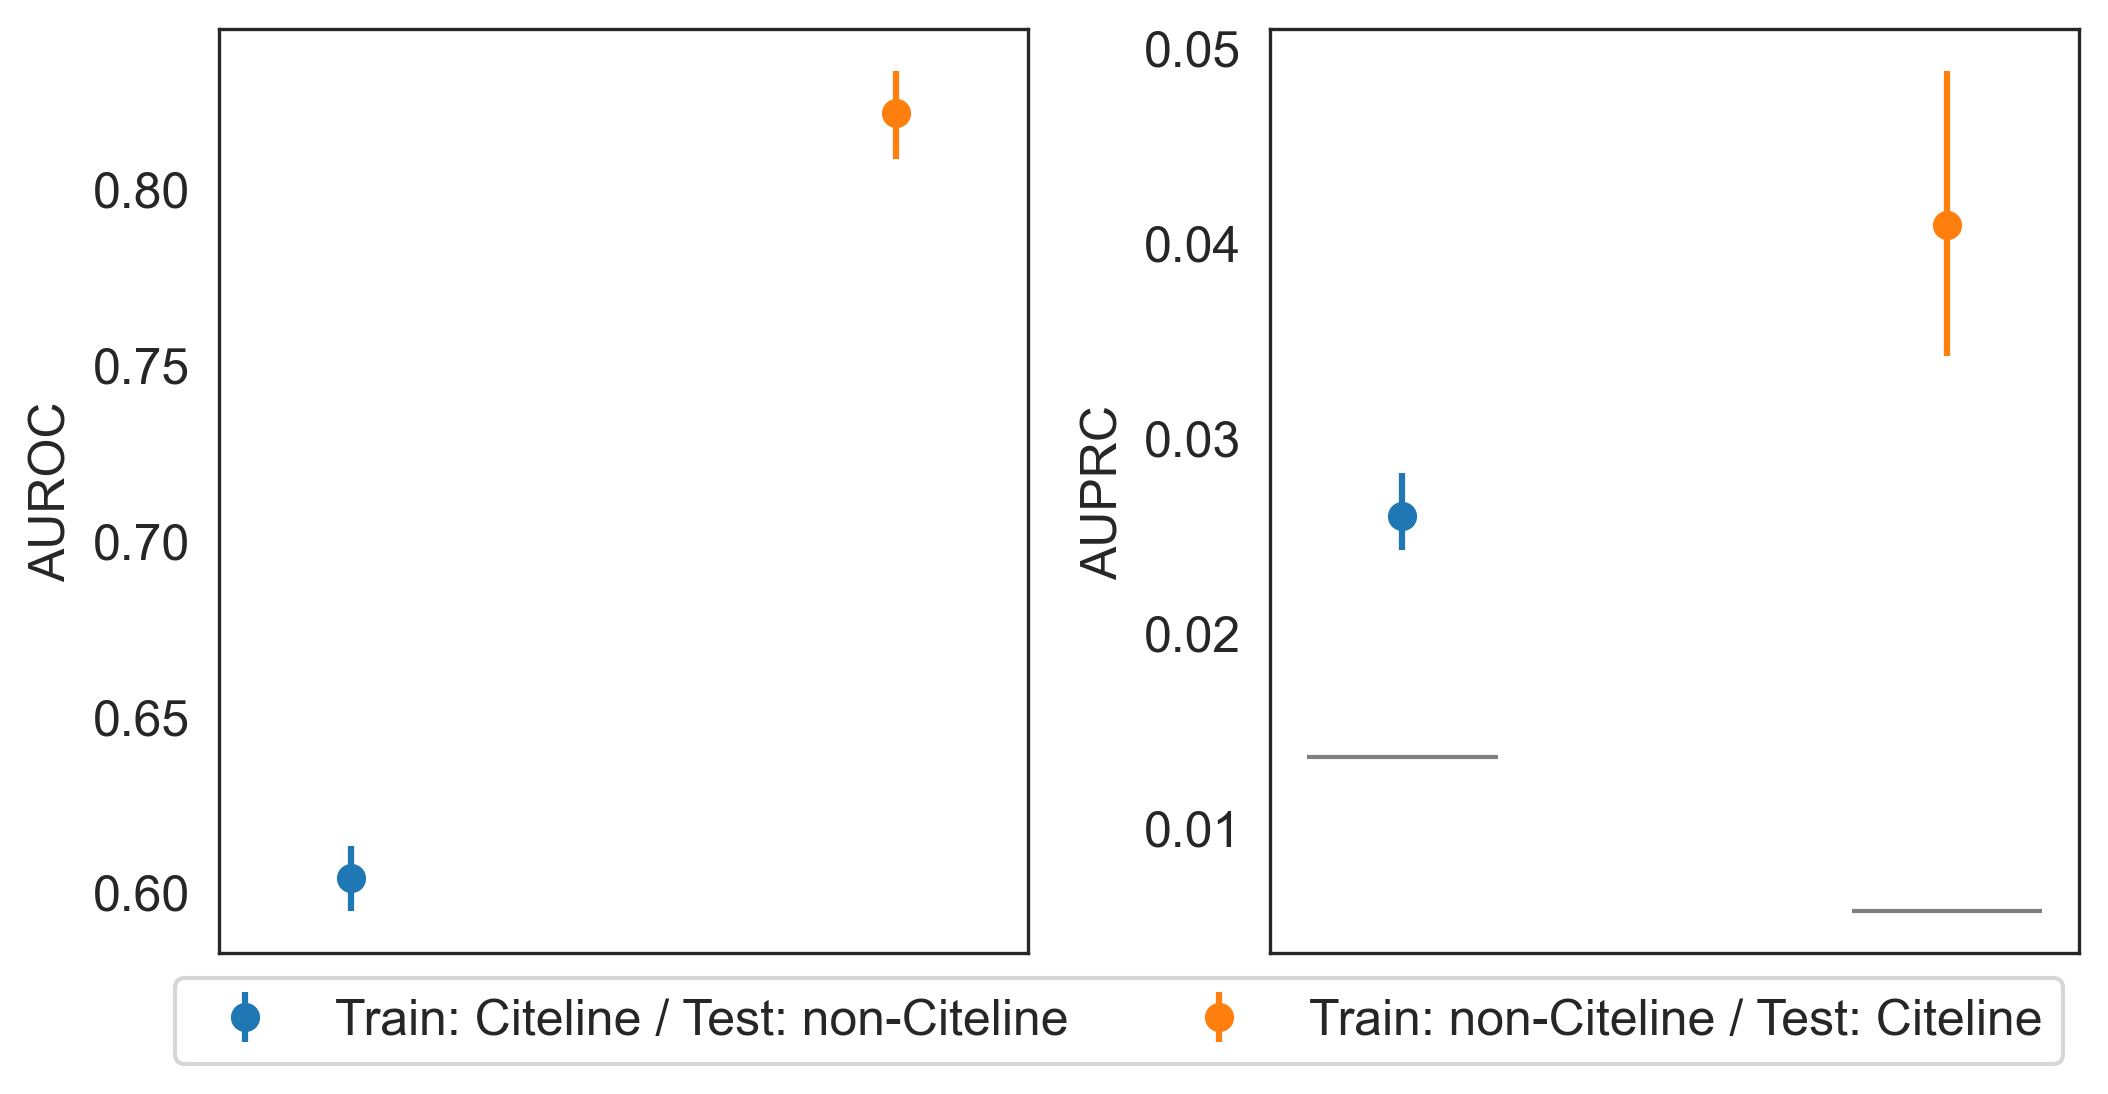

In [38]:
metrics = pd.read_excel("./Results/bootstrap_metrics_sensitivity_source.xlsx")
pdf = pd.read_pickle("./GPS/Sensitivity/source_holdout_predictions_ot_mantis_cc.pkl")

scenario_labels = {
    "train_Minikel_test_OT": "Train: Citeline / Test: non-Citeline",
    "train_OT_test_Minikel": "Train: non-Citeline / Test: Citeline",
}
metrics["Label"] = metrics["Scenario"].map(scenario_labels).fillna(metrics["Scenario"])

# Helper to parse CI strings like "('lower','mean','upper')" or "[lower, mean, upper]"
def parse_ci_str(ci_str):
    lo, mu, hi = ast.literal_eval(ci_str)
    return float(lo), float(mu), float(hi)

# AUROC prep
auroc_df = metrics.copy()
auroc_parsed = auroc_df["AUROC_CI"].apply(parse_ci_str)
auroc_df["AUROC_CI_lower"] = auroc_parsed.apply(lambda t: t[0])
auroc_df["AUROC_mean"] = auroc_parsed.apply(lambda t: t[1])
auroc_df["AUROC_CI_upper"] = auroc_parsed.apply(lambda t: t[2])
auroc_df["error_lower"] = auroc_df["AUROC_mean"] - auroc_df["AUROC_CI_lower"]
auroc_df["error_upper"] = auroc_df["AUROC_CI_upper"] - auroc_df["AUROC_mean"]

# AUPRC prep
# Baseline: positive class proportion per scenario from predictions
scenario_props = pdf.groupby("scenario")["indication"].mean().to_dict()

auprc_df = metrics.copy()
auprc_df["Proportion"] = auprc_df["Scenario"].map(scenario_props)
auprc_parsed = auprc_df["AUPRC_CI"].apply(parse_ci_str)
auprc_df["AUPRC_CI_lower"] = auprc_parsed.apply(lambda t: t[0])
auprc_df["AUPRC_mean"] = auprc_parsed.apply(lambda t: t[1])
auprc_df["AUPRC_CI_upper"] = auprc_parsed.apply(lambda t: t[2])
auprc_df["error_lower"] = auprc_df["AUPRC_mean"] - auprc_df["AUPRC_CI_lower"]
auprc_df["error_upper"] = auprc_df["AUPRC_CI_upper"] - auprc_df["AUPRC_mean"]

canonical_order = [
    "train_Minikel_test_OT",
    "train_OT_test_Minikel",
]
present = [s for s in canonical_order if s in set(metrics["Scenario"])]
pos = {s: i for i, s in enumerate(present)}

cat = pd.api.types.CategoricalDtype(categories=present, ordered=True)
auroc_df["Scenario"] = auroc_df["Scenario"].astype(cat)
auprc_df["Scenario"] = auprc_df["Scenario"].astype(cat)

# Plot
sns.set_style("white")

fig, axes = plt.subplots(1, 2, figsize=(8, 4), dpi=300, sharex=True)
fig.subplots_adjust(wspace=0.3)

# Use matplotlib's default color cycle
CB_color_cycle = plt.rcParams.get("axes.prop_cycle", None)
if CB_color_cycle is not None:
    CB_color_cycle = CB_color_cycle.by_key().get("color", [])
else:
    CB_color_cycle = []

width = 0.175

# -------- Left panel: AUROC --------
ax = axes[0]
for s in present:
    scen_data = auroc_df.loc[auroc_df["Scenario"] == s]
    if scen_data.empty:
        continue
    x_i = pos[s]
    color = CB_color_cycle[x_i % len(CB_color_cycle)] if CB_color_cycle else None

    ax.errorbar(
        x_i,
        scen_data["AUROC_mean"].values[0],
        yerr=[
            [scen_data["error_lower"].values[0]],
            [scen_data["error_upper"].values[0]],
        ],
        fmt="o",
        capsize=0,
        label=scen_data["Label"].values[0],
        color=color,
    )

ax.set_xticks(range(len(present)))
ax.set_xticklabels([])
ax.set_ylabel("AUROC")
ax.set_xlabel("")

# -------- Right panel: AUPRC --------
ax = axes[1]
for s in present:
    scen_data = auprc_df.loc[auprc_df["Scenario"] == s]
    if scen_data.empty:
        continue
    x_i = pos[s]
    color = CB_color_cycle[x_i % len(CB_color_cycle)] if CB_color_cycle else None

    ax.errorbar(
        x_i,
        scen_data["AUPRC_mean"].values[0],
        yerr=[
            [scen_data["error_lower"].values[0]],
            [scen_data["error_upper"].values[0]],
        ],
        fmt="o",
        capsize=0,
        label=scen_data["Label"].values[0],
        color=color,
    )

    # Horizontal baseline per scenario: prevalence
    prop = scen_data["Proportion"].iloc[0]
    if pd.notnull(prop):
        ax.hlines(
            y=prop,
            xmin=x_i - width,
            xmax=x_i + width,
            color="gray",
            linestyle="-",
            linewidth=1,
        )

ax.set_xticks(range(len(present)))
ax.set_xticklabels([])
ax.set_ylabel("AUPRC")

# -------- Single legend below both panels --------
handles, labels = axes[0].get_legend_handles_labels()
# Deduplicate legend entries while preserving order
seen = set()
dedup = [(h, l) for h, l in zip(handles, labels) if not (l in seen or seen.add(l))]
if dedup:
    handles, labels = zip(*dedup)
    fig.legend(handles, labels, loc="lower center", ncol=2, bbox_to_anchor=(0.5, -0.003))

plt.show()